# YouTube trending videos

In [1]:
%matplotlib inline
import random

import sys
sys.path.append("..")

import xgboost as xgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from helpers.files import load_csv

plt.rcParams["figure.facecolor"] = "#a9a9a9"
random.seed(0)
np.random.seed(0)


def print_stats(clf, x_train, y_train, x_test, y_test):
    y_train_pred = clf.predict(x_train)
    print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
    y_test_pred = clf.predict(x_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

# X, y = shap.datasets.boston()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
# # Random Forest
# rf = sklearn.ensemble.RandomForestRegressor()
# rf.fit(X_train, y_train)
#
# # K Nearest Neighbor
# knn = sklearn.neighbors.KNeighborsRegressor()
# knn.fit(X_train, y_train)
#
# # Tree on Random Forest
# explainerRF = shap.TreeExplainer(rf)
# shap_values_RF_test = explainerRF.shap_values(X_test)
# shap_values_RF_train = explainerRF.shap_values(X_train)
#
# # Random Forest
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)
#
# categorical_features = np.argwhere(np.array([len(set(X_train.values[:, x]))
#                                              for x in range(X_train.values.shape[1])]) <= 10).flatten()
#
# # LIME has one explainer for all models
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values,
#     feature_names=X_train.columns.values.tolist(),
#     class_names=['price'],
#     categorical_features=categorical_features,
#     verbose=True, mode='regression'
# )
#
# j = 0
# # initialize js for SHAP
# shap.initjs()
#
# exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

### Wczytanie danych

In [2]:
load_filtered = True
if load_filtered:
    videos = load_csv("ped6_filtered_data")[0]
else:
    videos = load_csv("ped6_data")[0]

videos = videos.sample(frac=1).reset_index(drop=True)
videos.head(5)

,title_len,channel_title_len,publish_time_day_of_week,color_mean_score,red_hist_score,edges_score,title_tfidf_2017,title_tfidf_2018,title_tfidf_day,title_tfidf_de,...,tags_tfidf_highlight,tags_tfidf_interview,tags_tfidf_live,tags_tfidf_music,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_tv,tags_tfidf_video,trending
0,12,5,3,930690.0,7759.097656,1679522.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.30995,0
1,79,3,2,1188606.0,7912.687500,1679221.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
2,35,12,0,928458.0,4543.202148,1679646.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
3,36,8,4,778872.0,8886.710938,1679836.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
4,49,20,6,1067052.0,3492.513184,1678746.0,0.0,0.0,0.0,0.0,...,0.0,0.67632,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0


### Przygotowanie danych

In [3]:
y = videos["trending"]
x = videos.loc[:, videos.columns != "trending"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

# y_test = np.where(y_test == 0, 1, 0)

x_train_stats = x_train.mean()

x_train = x_train.fillna(x_train_stats)
x_test = x_test.fillna(x_train_stats)

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")
x_train.head(5)

Train: (15022, 76)
Test: (3756, 76)


,title_len,channel_title_len,publish_time_day_of_week,color_mean_score,red_hist_score,edges_score,title_tfidf_2017,title_tfidf_2018,title_tfidf_day,title_tfidf_de,...,tags_tfidf_game,tags_tfidf_highlight,tags_tfidf_interview,tags_tfidf_live,tags_tfidf_music,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_tv,tags_tfidf_video
0,0.762887,0.135593,0.333333,0.539142,0.141066,0.348494,0.0,0.0,0.0,0.0,...,0.892669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.319588,0.186441,1.000000,0.407664,0.254865,0.479410,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.389831,1.000000,0.534571,0.312993,0.513985,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.484536,0.559322,0.666667,0.526800,0.301656,0.220037,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.402062,0.135593,0.500000,0.578554,0.190364,0.433620,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Wybór miar oceny klasyfikatorów

Accuracy
TODO wyjaśnij wybór.

### Wybór pierwszego klasyfikatora

RandomForest
TODO uzasadnij wybór.

In [102]:
param_grid = {
    "reduce_dim__k": [10, 30],  # range(1, 50, 5),
    "classifier__max_depth": [4, 8, 10],
    "classifier__min_samples_leaf": [1, 2],  # 2, 4],
    "classifier__n_estimators": [10, 50, 100, 200]

}

pipeline = Pipeline([
    ("reduce_dim", SelectKBest(chi2)),
    ("classifier", RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, n_jobs=8, param_grid=param_grid, cv=10, verbose=1, scoring="accuracy")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50, 'reduce_dim__k': 30}



### Uczenie pierwszego klasyfikatora

In [103]:
k = grid_search.best_params_["reduce_dim__k"]
max_depth = grid_search.best_params_["classifier__max_depth"]
min_samples_leaf = grid_search.best_params_["classifier__min_samples_leaf"]
n_estimators = grid_search.best_params_["classifier__n_estimators"]
# Tree on Random Forest
select = SelectKBest(chi2, k=k)

x_train_selected = select.fit_transform(x_train, y_train)
x_test_selected = select.transform(x_test)

mask = select.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
rf.fit(x_train_selected, y_train)


RandomForestClassifier(max_depth=10, n_estimators=50)

### Testowanie pierwszego klasyfikatora

In [104]:
print_stats(rf, x_train_selected, y_train, x_test_selected, y_test)
rf_pred = lambda x: rf.predict_proba(x).astype(float)


Train accuracy: 0.7281320729596592
Test accuracy: 0.724174653887114


### Interpretacja predykcji pierwszego klasyfikatora

Intercept -0.8300950568503054
Prediction_local [0.60062864]
Right: 0.5921803195653518


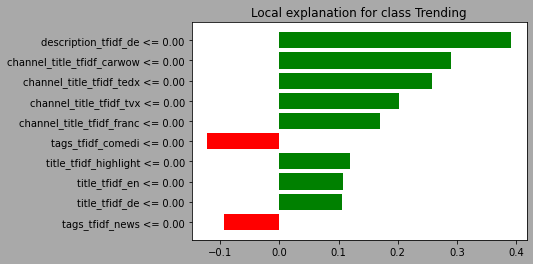

In [105]:
explainerRF = shap.TreeExplainer(rf)

# shap_values_RF_test = explainerRF.shap_values(x_test_selected, approximate=True)
# shap_values_RF_train = explainerRF.shap_values(x_train_selected, approximate=True)
# Random Forest
#TODO check index
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test[1], columns=x_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train[1], columns=x_train.columns.values)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train_selected.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 0
exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], rf_pred)
exp.save_to_file("lime.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [106]:
j = 123
x_test_selected.loc[[j]]

,title_tfidf_de,title_tfidf_en,title_tfidf_highlight,title_tfidf_la,title_tfidf_new,channel_title_tfidf_carwow,channel_title_tfidf_cocina,channel_title_tfidf_de,channel_title_tfidf_fallon,channel_title_tfidf_franc,...,description_tfidf_de,description_tfidf_watch,tags_tfidf_2018,tags_tfidf_comedi,tags_tfidf_de,tags_tfidf_fallon,tags_tfidf_funni,tags_tfidf_highlight,tags_tfidf_new,tags_tfidf_news
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.139075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
print(y_test.to_numpy()[j])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP

shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


1
(2, 1, 30)


In [108]:
j = 3500
x_test_selected.loc[[j]]

,title_tfidf_de,title_tfidf_en,title_tfidf_highlight,title_tfidf_la,title_tfidf_new,channel_title_tfidf_carwow,channel_title_tfidf_cocina,channel_title_tfidf_de,channel_title_tfidf_fallon,channel_title_tfidf_franc,...,description_tfidf_de,description_tfidf_watch,tags_tfidf_2018,tags_tfidf_comedi,tags_tfidf_de,tags_tfidf_fallon,tags_tfidf_funni,tags_tfidf_highlight,tags_tfidf_new,tags_tfidf_news
3500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
print(y_test.to_numpy()[j])
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


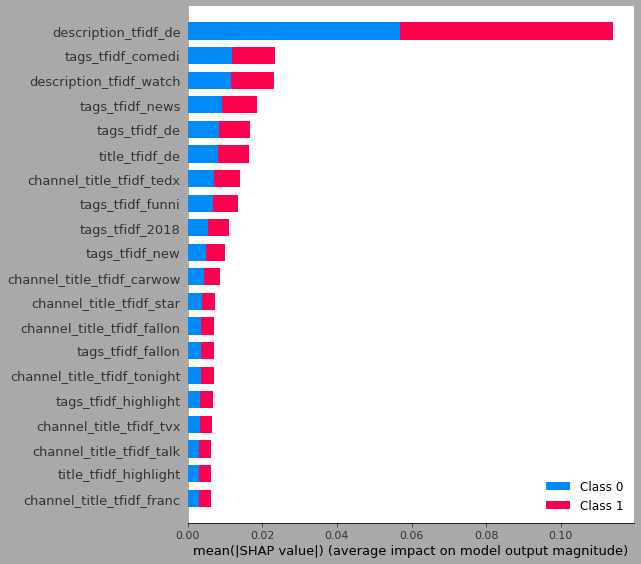

In [110]:
shap.summary_plot(shap_val, x_test_selected.loc[[j]])
# shap.summary_plot(shap_values_RF_train[0], x_train_selected)


# TODO pomyśl o filtrowaniu danych
# TODO pomyśl o odfiltrowaniu innych języków

## Drugi klasyfikator

### Wybór drugiego klasyfikatora

In [70]:
from sklearn.metrics import classification_report, accuracy_score

xgbclf_base = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, verbose=0)

print(xgbclf_base.fit(x_train, y_train))

y_pred = xgbclf_base.predict(x_test)

print(classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbose=0, verbosity=None)
              precision    recall  f1-score   support

    trending       0.89      0.93      0.91      1831
non-trending       0.93      0.89      0.91      1925

    accuracy                           0.91      3756
   macro avg       0.91      0.91      0.91      3756
weighted avg       0.91      0.91      0.91      3756



In [55]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 2, 5],
        'max_depth': [3, 6, 9, 15]
}

xgbclf_par = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, nthread=1, verbosity = 0)
grid_search = GridSearchCV(xgbclf_par, n_jobs=8, param_grid=params, cv=3, verbose=1)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'gamma': 0, 'max_depth': 9, 'min_child_weight': 1}


In [71]:
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_score_)

[0.74610602 0.74903542 0.75236418 0.79563338 0.79423512 0.78797741
 0.82046386 0.81114391 0.80768194 0.84109946 0.82685393 0.81919876
 0.83564077 0.83351139 0.8318468  0.74610602 0.74903542 0.74810347
 0.80082524 0.79190534 0.79123955 0.81666879 0.81114395 0.80754881
 0.83657317 0.82665444 0.81859949 0.8365067  0.83151377 0.82798615
 0.74763721 0.74903542 0.7457734  0.79609927 0.79090699 0.78631375
 0.81627011 0.80794884 0.81107717 0.83064843 0.82598917 0.81500456
 0.83351123 0.82499014 0.82585592]
0.8410994575645215


### Uczenie drugiego klasyfikatora

In [68]:
min_child_weight = grid_search.best_params_["min_child_weight"]
max_depth = grid_search.best_params_["max_depth"]
gamma = grid_search.best_params_["gamma"]

xgbclf = xgb.XGBClassifier(n_estimators=1000,  use_label_encoder=False, nthread=-1, verbosity = 0, objective= 'binary:logistic',
min_child_weight = min_child_weight,
max_depth = max_depth,
gamma = gamma)

xgbclf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

### Testowanie drugiego klasyfikatora

In [105]:
print_stats(xgbclf, x_train, y_train, x_test, y_test)
y_pred = xgbclf.predict(x_test)
print("Test results: \n",classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

Train accuracy: 0.9999334309679138
Test accuracy: 0.9110756123535676
Test results: 
               precision    recall  f1-score   support

    trending       0.90      0.92      0.91      1831
non-trending       0.92      0.90      0.91      1925

    accuracy                           0.91      3756
   macro avg       0.91      0.91      0.91      3756
weighted avg       0.91      0.91      0.91      3756



### Interpretacja predykcji drugiego klasyfikatora

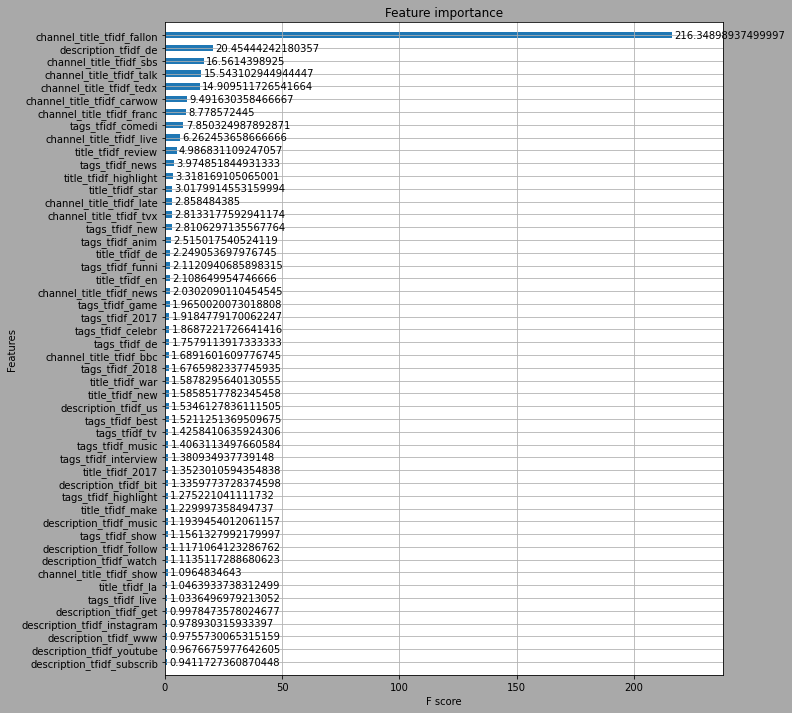

In [102]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

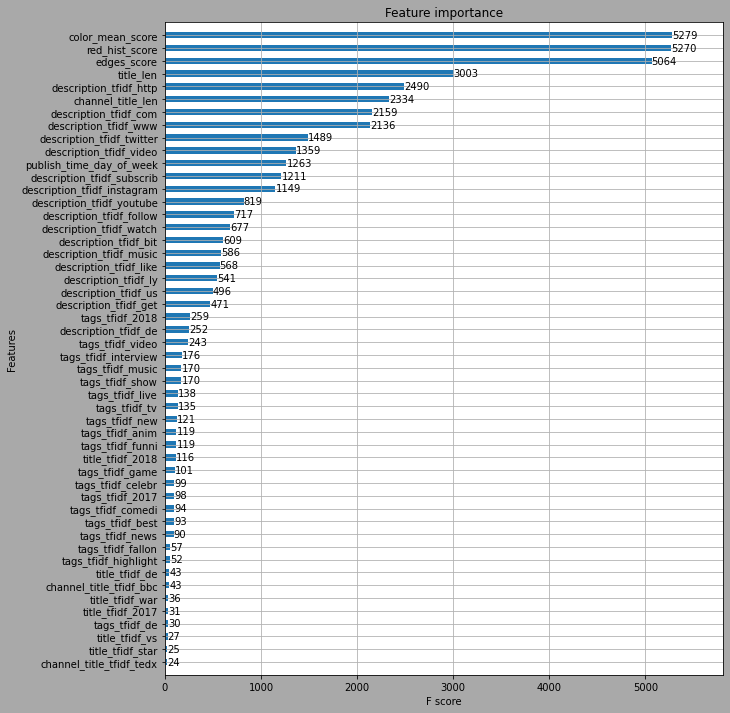

In [104]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show()

Intercept -0.6963866559328458
Prediction_local [0.97335148]
Right: 0.9930805563926697


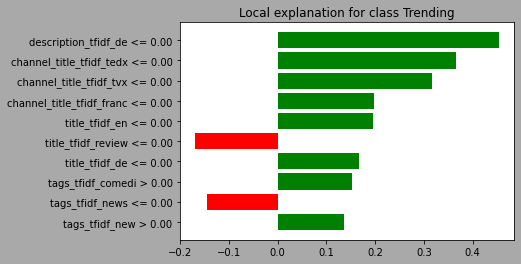

In [99]:
xgb_pred = lambda x: xgbclf.predict_proba(x).astype(float)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train.values,
    feature_names=x_train.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 3

exp = explainer.explain_instance(x_test.loc[[j]].values[0], xgb_pred)
exp.save_to_file("lime2.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [95]:
x_sampled = x_test.sample(100, random_state=0)
explainerXgb = shap.TreeExplainer(xgbclf)
shap_values = explainerXgb.shap_values(x_sampled)


In [96]:
shap.force_plot(explainerXgb.expected_value, shap_values[0,:], x_sampled.iloc[0,:])

In [88]:
shap.force_plot(explainerXgb.expected_value, shap_values, x_train)

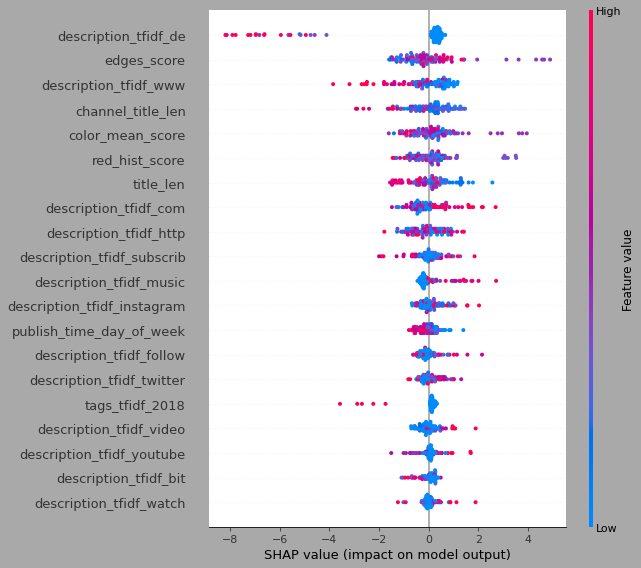

In [90]:
shap.summary_plot(shap_values, x_sampled)

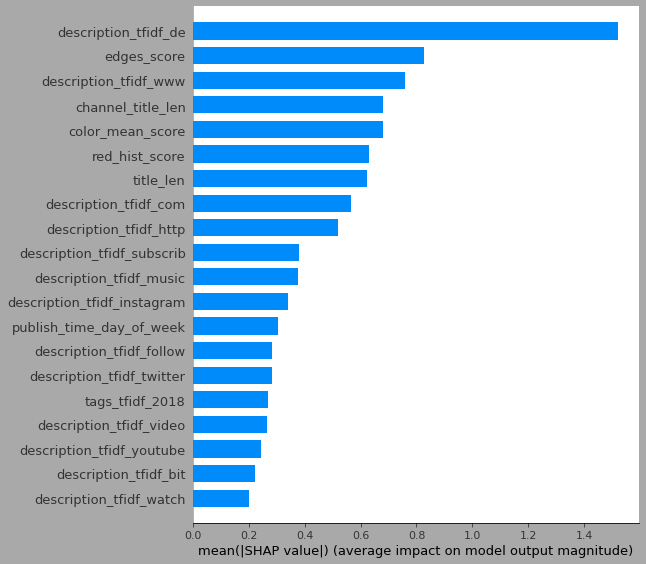

In [97]:
shap.summary_plot(shap_values, x_sampled, plot_type="bar")

### Wybór klasyfikatora

### Uczenie klasyfikatora

### Wybór drugiego klasyfikatora

### Testowanie klasyfikatora
### Uczenie drugiego klasyfikatora

### Interpretacja predykcji

### Testowanie drugiego klasyfikatora

### Interpretacja predykcji drugiego klasyfikatora

### Porównanie wyników klasyfikatorów

### Wiedza dla klienta
Profil harakterystycznych wartości atrybutów dla klasy trending

Co trzeba robić?

Czego się wystrzegać?